<a href="https://colab.research.google.com/github/wilhayla/THE-HUDDLE-CHALLENGE_04-CONSULTA-MORTAL/blob/main/Copia_de_web_scruping_ch4_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTAR LIBRERIAS

In [ ]:
from bs4 import BeautifulSoup
import requests
import sqlite3
import pandas as pd
import re
from urllib.parse import urljoin
import time
import matplotlib.pyplot as plt

## CREAR BASE DE DATOS Y TABLAS

In [ ]:
# Conectar a la base de datos
conn = sqlite3.connect('coleccion_libros.db')

# Crear un cursor
c = conn.cursor()

# Crear las tablas Libros
c.execute("""CREATE TABLE libros(
  id_libros integer PRIMARY KEY AUTOINCREMENT NOT NULL UNIQUE,
  Titulo text,
  Precio_Libras text,
  Estrellas text,
  Disponibilidad text,
  UPC text
)
""")

conn.commit()
conn.close()

In [ ]:
conn = sqlite3.connect('coleccion_libros.db')

c = conn.cursor()

# Crear las tablas Categorias
c.execute("""CREATE TABLE categoria(
  id_categoria integer PRIMARY KEY AUTOINCREMENT NOT NULL UNIQUE,
  Nombre text
)
""")

conn.commit()
conn.close()

In [ ]:
conn = sqlite3.connect('coleccion_libros.db')

c = conn.cursor()

c.execute('''
CREATE TABLE libros_categorias (
    id_libros INTEGER NOT NULL,
    id_categoria INTEGER NOT NULL,
    PRIMARY KEY (id_libros, id_categoria),
    FOREIGN KEY (id_libros) REFERENCES libros(id_libros),
    FOREIGN KEY (id_categoria) REFERENCES categoria(id_categoria)
)
''')

conn.commit()
conn.close()

## INICIAR EL WEB SCRUPING

In [ ]:
# web scruping

# 1. Obtener el HTML
url_base = "https://books.toscrape.com/"
r = requests.get(url_base)

html_obtenido = r.text

# 2. Pasear el HTML obtenido.
soup = BeautifulSoup(html_obtenido, "html.parser")
print(soup)

<!DOCTYPE html>

<!--[if lt IE 7]>      <html lang="en-us" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html lang="en-us" class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html lang="en-us" class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-us"> <!--<![endif]-->
<head>
<title>
    All products | Books to Scrape - Sandbox
</title>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="24th Jun 2016 09:29" name="created"/>
<meta content="" name="description"/>
<meta content="width=device-width" name="viewport"/>
<meta content="NOARCHIVE,NOCACHE" name="robots"/>
<!-- Le HTML5 shim, for IE6-8 support of HTML elements -->
<!--[if lt IE 9]>
        <script src="//html5shim.googlecode.com/svn/trunk/html5.js"></script>
        <![endif]-->
<link href="static/oscar/favicon.ico" rel="shortcut icon"/>
<link href="static/oscar/css/styles.css" rel="stylesheet" type="text/css"/>
<link href="s



## EXTRAER LOS ENLACES DE CATEGORIAS A PARTIR DEL PANEL LATERAL



In [ ]:
try:
  sidebar = soup.find('aside', class_ = 'sidebar')
  side_categories_div = sidebar.find('div', class_ = 'side_categories')
  categorias_contendedor = side_categories_div.find('ul', class_ = 'nav nav-list').find('ul')
  enlaces_categorias = categorias_contendedor.find_all('a')
  print(enlaces_categorias)

except (AttributeError, TypeError):
    print("No se pudo encontrar la estructura de categorías.")


[<a href="catalogue/category/books/travel_2/index.html">
                            
                                Travel
                            
                        </a>, <a href="catalogue/category/books/mystery_3/index.html">
                            
                                Mystery
                            
                        </a>, <a href="catalogue/category/books/historical-fiction_4/index.html">
                            
                                Historical Fiction
                            
                        </a>, <a href="catalogue/category/books/sequential-art_5/index.html">
                            
                                Sequential Art
                            
                        </a>, <a href="catalogue/category/books/classics_6/index.html">
                            
                                Classics
                            
                        </a>, <a href="catalogue/category/books/phil

## ITERAR SOBRE CADA ENLACE DE CATEGORIAS Y CADA LIBRO
## E INSERTAR LOS DATOS EN LAS TABLAS

In [ ]:
conn = sqlite3.connect('coleccion_libros.db')
c = conn.cursor()

for enlace in enlaces_categorias:
  nombre_categoria = enlace.text.strip()

  c.execute("INSERT OR IGNORE INTO categoria(Nombre) VALUES(?)", (nombre_categoria,))
  conn.commit()

  c.execute("SELECT id_categoria FROM categoria WHERE nombre = ?", (nombre_categoria,))
  id_categoria_actual = c.fetchone()[0]  # obtiene el valor de la clave primaria

  url_relativa_categorias = enlace['href']

  # concatenar para obtener la url completa de las categorias
  url_completa_categorias = urljoin(url_base, url_relativa_categorias)

  print(f"--- Scrapeando la categoría: {nombre_categoria} ---")
  print(f"URL: {url_completa_categorias}\n")

  while True:
    try:
      response_categoria = requests.get(url_completa_categorias)
      response_categoria.raise_for_status() # Lanza un error si la solicitud falla

      soup_categorias = BeautifulSoup(response_categoria.text, "html.parser")

      # Encontrar todos los libros en la pagina de categorias
      libros_en_categorias = soup_categorias.find_all('article', class_ = "product_pod")

      # Bucle anidado: iterar sobre cada libro de la categoria actual
      for libro in libros_en_categorias:
        # Obtener la URL relativa del libro y completa del libro
        url_relativa_libro = libro.h3.a['href']
        url_completa_libro = urljoin(url_completa_categorias, url_relativa_libro)
        print(f"  - Accediendo al libro: {libro.h3.a['title']}")
        print(f"    URL del libro: {url_completa_libro}")

        # Establecer coneccion con la pagina del libro y parsear.
        response_libro = requests.get(url_completa_libro)
        response_libro.raise_for_status()
        soup_libro = BeautifulSoup(response_libro.text, "html.parser")

        # Obtener los datos del libro
        titulo_libro = soup_libro.find('h1')
        titulo = titulo_libro.text

        rating_etiqueta = libro.find('p', class_=re.compile(r'^star-rating'))

        if rating_etiqueta:
              clases_rating = rating_etiqueta['class'] # devuelve una lista [star-rating, one]

              # El rating (e.g., 'Two', 'Three') es el segundo elemento de la lista.
              rating_estrellas = clases_rating[1]
        else:
          rating_estrellas = "No se encontro ningun rating"

        tabla_info = soup_libro.find('table', class_ = "table table-striped")
        valores_tabla = [celda.text for celda in tabla_info.find_all('td')]

        upc = valores_tabla[0]
        precio_incl_tax = valores_tabla[3]
        # Remover el caracter 'Â' y el simbolo '£' antes de convertir a float
        precio_sin_simbolo = precio_incl_tax.replace('Â', '').replace('£', '')
        precio_convert_numero = float(precio_sin_simbolo)
        disponibilidad = valores_tabla[5]

        # Verificar si el libro ya existe en la base de datos
        c.execute("SELECT id_libros FROM libros WHERE upc = ?", (upc,))
        resultado_libro = c.fetchone()

        if resultado_libro:
          id_libro_actual = resultado_libro[0]
        else:
          c.execute('''INSERT INTO libros
          (Titulo, Precio_Libras, Estrellas, Disponibilidad, UPC) VALUES(?,?,?,?,?)''',
          (titulo, precio_convert_numero, rating_estrellas, disponibilidad, upc))
          id_libro_actual = c.lastrowid
          print(f"   -Nuevo libro '{titulo}' insertado")

        c.execute('''INSERT OR IGNORE INTO libros_categorias
        (id_libros, id_categoria) VALUES(?,?)''',
        (id_libro_actual, id_categoria_actual))

        print(f"   - Relacion entre libro y categoria guardada.")
        time.sleep(1)

      siguiente_pagina_li = soup_categorias.find('li', class_ = 'next')
      if siguiente_pagina_li:
        url_relativa_siguiente_pagina = siguiente_pagina_li.find('a')['href']
        url_completa_siguiente_pagina = urljoin(url_completa_categorias, url_relativa_siguiente_pagina)
        print(f"Pasando a la siguiente pagina: {url_completa_siguiente_pagina}")
        url_completa_categorias = url_completa_siguiente_pagina # Update URL for the next iteration
        time.sleep(1)
      else:
        print("No se encontraron mas paginas.")
        break

    except requests.exceptions.RequestException as e:
          print(f"  Error al acceder a la URL: {url_completa_categorias}")
          print(f"  Detalles del error: {e}")
          break

  print("\n" + "=" * 60 + "\n")

conn.commit()
conn.close()

print("Scraping y almacenamiento en la base de datos completado.")

--- Scrapeando la categoría: Travel ---
URL: https://books.toscrape.com/catalogue/category/books/travel_2/index.html

  - Accediendo al libro: It's Only the Himalayas
    URL del libro: https://books.toscrape.com/catalogue/its-only-the-himalayas_981/index.html
   -Nuevo libro 'It's Only the Himalayas' insertado
   - Relacion entre libro y categoria guardada.
  - Accediendo al libro: Full Moon over Noahâs Ark: An Odyssey to Mount Ararat and Beyond
    URL del libro: https://books.toscrape.com/catalogue/full-moon-over-noahs-ark-an-odyssey-to-mount-ararat-and-beyond_811/index.html
   -Nuevo libro 'Full Moon over Noahâs Ark: An Odyssey to Mount Ararat and Beyond' insertado
   - Relacion entre libro y categoria guardada.
  - Accediendo al libro: See America: A Celebration of Our National Parks & Treasured Sites
    URL del libro: https://books.toscrape.com/catalogue/see-america-a-celebration-of-our-national-parks-treasured-sites_732/index.html
   -Nuevo libro 'See America: A Celebration

## CREAR INDICES PARA LAS TABLAS

In [ ]:
conn = sqlite3.connect('coleccion_libros.db')
c = conn.cursor()

c.execute("CREATE INDEX idx_categorias_nombre ON categoria(nombre);")
c.execute("CREATE INDEX idx_libros_titulo ON libros(titulo);")
c.execute("CREATE INDEX idx_libros_categorias ON libros_categorias(id_libros, id_categoria);")


conn.commit()
conn.close()

## HACIENDO CONSULTAS

## Pedir todos los libros de la categoria TRAVEL, mostrar titulos y categoria

In [ ]:
conn = sqlite3.connect('coleccion_libros.db')
c = conn.cursor()

query_libros_travel = """
SELECT libros.titulo, categoria.nombre
FROM libros_categorias
JOIN libros ON libros_categorias.id_libros = libros.id_libros
JOIN categoria ON libros_categorias.id_categoria = categoria.id_categoria
WHERE categoria.Nombre = 'Travel';
"""

df_libros_travel = pd.read_sql_query(query_libros_travel, conn)   # utilizacion de pandas

print("Libros de la categoria 'Travel':")
print(df_libros_travel.head(10))

conn.close()

Libros de la categoria 'Travel':
                                              Titulo  Nombre
0                            It's Only the Himalayas  Travel
1  Full Moon over Noahâs Ark: An Odyssey to Mou...  Travel
2  See America: A Celebration of Our National Par...  Travel
3  Vagabonding: An Uncommon Guide to the Art of L...  Travel
4                               Under the Tuscan Sun  Travel
5                                 A Summer In Europe  Travel
6                           The Great Railway Bazaar  Travel
7                   A Year in Provence (Provence #1)  Travel
8  The Road to Little Dribbling: Adventures of an...  Travel
9          Neither Here nor There: Travels in Europe  Travel


## Pedir libros que tengan valorizacion de 1 estrella, mostrar titulo y estrellas


In [ ]:
conn = sqlite3.connect('coleccion_libros.db')
c = conn.cursor()

query_libros_1_estrellas = """
SELECT titulo, estrellas
FROM libros
WHERE estrellas = 'One';
"""

df_libros_1_estrellas = pd.read_sql_query(query_libros_1_estrellas, conn)
cantidad_libros_1_estrellas = len(df_libros_1_estrellas)

print("Libros con rating de estrellas 'Uno':")
print(f"Cantidad de libros con rating de estrellas 'Uno': {cantidad_libros_1_estrellas}")
print(df_libros_1_estrellas.head(10))

conn.close()

Libros con rating de estrellas 'Uno':
Cantidad de libros con rating de estrellas 'Uno': 226
                                              Titulo Estrellas
0                           The Great Railway Bazaar       One
1  The Road to Little Dribbling: Adventures of an...       One
2                               In a Dark, Dark Wood       One
3                                   A Murder in Time       One
4             That Darkness (Gardiner and Renner #1)       One
5               Tastes Like Fear (DI Marnie Rome #3)       One
6                         Hide Away (Eve Duncan #20)       One
7          The Cuckoo's Calling (Cormoran Strike #1)       One
8                1st to Die (Women's Murder Club #1)       One
9                                 Tipping the Velvet       One


## Mostrar todos los libros que tengan 2 estrellas, mostrar titulo y categoria


In [ ]:
conn = sqlite3.connect('coleccion_libros.db')
c = conn.cursor()

query_libros_2_estrellas = """
SELECT titulo, estrellas
FROM libros
WHERE estrellas = 'Two';
"""

df_libros_2_estrellas = pd.read_sql_query(query_libros_2_estrellas, conn)
cantidad_libros_2_estrellas = len(df_libros_2_estrellas)

print("Libros con rating de estrellas 'Dos':")
print(f"Cantidad de libros con rating de estrellas 'Dos': {cantidad_libros_2_estrellas}")
print(" ")
print(df_libros_2_estrellas.head(10))

conn.close()

Libros con rating de estrellas 'Dos':
Cantidad de libros con rating de estrellas 'Dos': 196
 
                                              Titulo Estrellas
0                            It's Only the Himalayas       Two
1  Vagabonding: An Uncommon Guide to the Art of L...       Two
2                                 A Summer In Europe       Two
3                     The Last Mile (Amos Decker #2)       Two
4            A Study in Scarlet (Sherlock Holmes #1)       Two
5                                          The Widow       Two
6              In the Woods (Dublin Murder Squad #1)       Two
7                Career of Evil (Cormoran Strike #3)       Two
8                               Love, Lies and Spies       Two
9                                        Lilac Girls       Two


## Pedir libros con 3 estrellas, mostrar tiutlo y estrellas y categorias

In [ ]:
conn = sqlite3.connect('coleccion_libros.db')
c = conn.cursor()

query_libros_3_estrellas = """
SELECT libros.titulo, libros.estrellas, categoria.nombre
FROM libros_categorias
JOIN libros ON libros.id_libros = libros_categorias.id_libros
JOIN categoria ON libros_categorias.id_categoria = categoria.id_categoria
WHERE libros.estrellas = 'Three';
"""

df_libros_3_estrellas = pd.read_sql_query(query_libros_3_estrellas, conn)
cantidad_libros_3_estrellas = len(df_libros_3_estrellas)

print("Libros con rating de estrellas 'Tres':")
print(f"Cantidad de libros con rating de estrellas 'Tres': {cantidad_libros_3_estrellas}")
print(df_libros_3_estrellas.head(10))

conn.close()

Libros con rating de estrellas 'Tres':
Cantidad de libros con rating de estrellas 'Tres': 203
                                              Titulo Estrellas   Nombre
0  See America: A Celebration of Our National Par...     Three   Travel
1                               Under the Tuscan Sun     Three   Travel
2          Neither Here nor There: Travels in Europe     Three   Travel
3                   Poisonous (Max Revere Novels #3)     Three  Mystery
4                                        Most Wanted     Three  Mystery
5                      Boar Island (Anna Pigeon #19)     Three  Mystery
6                                  Playing with Fire     Three  Mystery
7                                         The Exiled     Three  Mystery
8                 Extreme Prey (Lucas Davenport #26)     Three  Mystery
9          The Girl In The Ice (DCI Erika Foster #1)     Three  Mystery


## Mostrar libros con 4 estrellas, mostrar titulo, estrellas y categoria

In [ ]:
conn = sqlite3.connect('coleccion_libros.db')
c = conn.cursor()

query_libros_4_estrellas = """
SELECT libros.titulo, libros.estrellas, categoria.nombre
FROM libros_categorias
JOIN libros ON libros.id_libros = libros_categorias.id_libros
JOIN categoria ON libros_categorias.id_categoria = categoria.id_categoria
WHERE libros.estrellas = 'Four';
"""

df_libros_4_estrellas = pd.read_sql_query(query_libros_4_estrellas, conn)
cantidad_libros_4_estrellas = len(df_libros_4_estrellas)

print("Libros con rating de estrellas 'Cuatro':")
print(f"Cantidad de libros con rating de estrellas 'Cuatro': {cantidad_libros_4_estrellas}")
print(df_libros_4_estrellas.head(10))

conn.close()

Libros con rating de estrellas 'Cuatro':
Cantidad de libros con rating de estrellas 'Cuatro': 179
                                              Titulo Estrellas  \
0  Full Moon over Noahâs Ark: An Odyssey to Mou...      Four   
1                   A Year in Provence (Provence #1)      Four   
2                                      Sharp Objects      Four   
3                                The Past Never Ends      Four   
4    The Murder of Roger Ackroyd (Hercule Poirot #4)      Four   
5  Murder at the 42nd Street Library (Raymond Amb...      Four   
6   Delivering the Truth (Quaker Midwife Mystery #1)      Four   
7  The Mysterious Affair at Styles (Hercule Poiro...      Four   
8  The No. 1 Ladies' Detective Agency (No. 1 Ladi...      Four   
9                          The Marriage of Opposites      Four   

               Nombre  
0              Travel  
1              Travel  
2             Mystery  
3             Mystery  
4             Mystery  
5             Mystery  
6      

## Pedir libros que tengan 5 estrellas, mostrar titulo, estrellas y categoria.

In [ ]:
conn = sqlite3.connect('coleccion_libros.db')
c = conn.cursor()

query_libros_5_estrellas = """
SELECT libros.titulo, libros.estrellas, categoria.nombre
FROM libros_categorias
JOIN libros ON libros.id_libros = libros_categorias.id_libros
JOIN categoria ON libros_categorias.id_categoria = categoria.id_categoria
WHERE libros.estrellas = 'Five';
"""

df_libros_5_estrellas = pd.read_sql_query(query_libros_5_estrellas, conn)
cantidad_libros_5_estrellas = len(df_libros_5_estrellas)

print("Libros con rating de estrellas 'Five':")
print(f"Cantidad de libros con rating de estrellas 'Cinco': {cantidad_libros_5_estrellas}")
print(df_libros_5_estrellas.head(10))

conn.close()

Libros con rating de estrellas 'Five':
Cantidad de libros con rating de estrellas 'Cinco': 196
                                              Titulo Estrellas  \
0                 1,000 Places to See Before You Die      Five   
1             A Time of Torment (Charlie Parker #14)      Five   
2  What Happened on Beale Street (Secrets of the ...      Five   
3  The Bachelor Girl's Guide to Murder (Herringfo...      Five   
4                  The Silkworm (Cormoran Strike #2)      Five   
5                                  The Girl You Lost      Five   
6            A Flight of Arrows (The Pathfinders #2)      Five   
7                                       Mrs. Houdini      Five   
8                              The Passion of Dolssa      Five   
9                             Voyager (Outlander #3)      Five   

               Nombre  
0              Travel  
1             Mystery  
2             Mystery  
3             Mystery  
4             Mystery  
5             Mystery  
6  Histori

## Mostrar un libro y a que categorias pertenece

In [ ]:
conn = sqlite3.connect('coleccion_libros.db')
c = conn.cursor()

query_libros = """
SELECT libros.titulo, categoria.nombre
FROM libros_categorias
JOIN libros ON libros.id_libros = libros_categorias.id_libros
JOIN categoria ON libros_categorias.id_categoria = categoria.id_categoria
WHERE libros.id_libros = 40;
"""

df_libro = pd.read_sql_query(query_libros, conn)

print("Categorias del libro.")
print(df_libro.head(10))


conn.close()

Categorias del libro.
              Titulo   Nombre
0  The Girl You Lost  Mystery


## Hacer una query de todo, y agregar las categorias. Mostrar las ultimas 10 filas

In [ ]:
conn = sqlite3.connect('coleccion_libros.db')
c = conn.cursor()

query_todo = """
SELECT libros.titulo, libros.precio_libras, libros.estrellas, libros.disponibilidad, libros.upc, categoria.nombre
FROM libros_categorias
JOIN libros ON libros.id_libros = libros_categorias.id_libros
JOIN categoria ON libros_categorias.id_categoria = categoria.id_categoria;
"""

df_todo= pd.read_sql_query(query_todo, conn)
cantidad_libros_total= len(df_todo)

print(f"Cantidad de libros total: {cantidad_libros_total}")
print(df_todo.tail(10))

conn.close()

Cantidad de libros total: 1000
                                                Titulo Precio_Libras  \
990  The Bulletproof Diet: Lose up to a Pound a Day...         49.05   
991                                  Eat Fat, Get Thin         54.07   
992  10-Day Green Smoothie Cleanse: Lose Up to 15 P...         49.71   
993     The Art and Science of Low Carbohydrate Living         52.98   
994                       Libertarianism for Beginners         51.33   
995  Why the Right Went Wrong: Conservatism--From G...         52.65   
996  Equal Is Unfair: America's Misguided Fight Aga...         56.86   
997                                     Amid the Chaos         36.58   
998                                         Dark Notes         19.19   
999  The Long Shadow of Small Ghosts: Murder and Me...         10.97   

    Estrellas           Disponibilidad               UPC    Nombre  
990     Three  In stock (16 available)  43c6a960757cf559    Health  
991       Two  In stock (14 available)

## Codigo para graficar con MATPLOTLIB

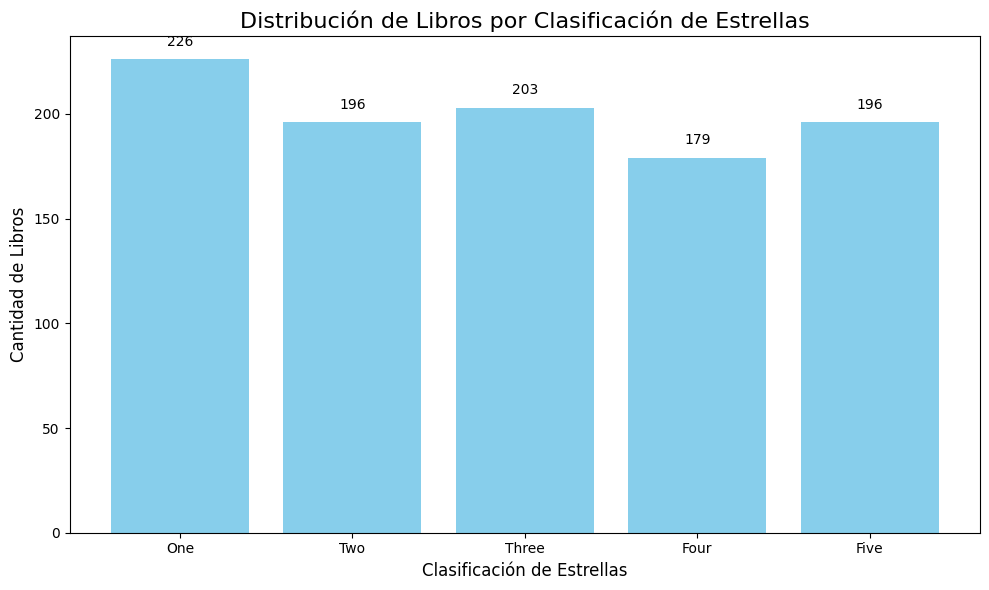

In [ ]:
# Conexión a la base de datos
conn = sqlite3.connect('coleccion_libros.db')

# Mapeo de valores de estrellas para ordenar el gráfico
mapeo_estrellas = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}

# Consulta SQL para obtener la cantidad de libros por cada número de estrellas
# Esta consulta es la forma más eficiente de obtener los datos para el gráfico
query_conteo_estrellas = """
SELECT Estrellas, COUNT(*) as cantidad
FROM libros
GROUP BY estrellas;
"""

# Ejecutar la consulta y cargar los resultados en un DataFrame
df_conteo_estrellas = pd.read_sql_query(query_conteo_estrellas, conn)

# Cerrar la conexión a la base de datos
conn.close()

# Mapear los nombres de estrellas a números para ordenarlos
df_conteo_estrellas['estrellas_numericas'] = df_conteo_estrellas['Estrellas'].map(mapeo_estrellas)

# Asegurarse de que el DataFrame esté ordenado por el número de estrellas
df_conteo_estrellas = df_conteo_estrellas.sort_values('estrellas_numericas')

# Crear el gráfico de barras
plt.figure(figsize=(10, 6)) # Define el tamaño de la figura
plt.bar(df_conteo_estrellas['Estrellas'], df_conteo_estrellas['cantidad'], color='skyblue')


# Añadir la cantidad de libros como texto sobre cada barra
for index, row in enumerate(df_conteo_estrellas.iterrows()):
    plt.text(index, row[1]['cantidad'] + 5, str(row[1]['cantidad']), ha='center', va='bottom')

plt.title('Distribución de Libros por Clasificación de Estrellas', fontsize=16)
plt.xlabel('Clasificación de Estrellas', fontsize=12)
plt.ylabel('Cantidad de Libros', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Conexión a la base de datos
conn = sqlite3.connect('coleccion_libros.db')

# Mapeo de valores de estrellas para ordenar el gráfico
mapeo_estrellas = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}

# Consulta SQL para obtener la cantidad de libros por cada número de estrellas
# Esta consulta es la forma más eficiente de obtener los datos para el gráfico
query_conteo_estrellas = """
SELECT Estrellas, COUNT(*) as cantidad
FROM libros
GROUP BY estrellas;
"""

# Ejecutar la consulta y cargar los resultados en un DataFrame
df_conteo_estrellas = pd.read_sql_query(query_conteo_estrellas, conn)
#df_conteo_estrellas['estrellas_numericas'] = df_conteo_estrellas['Estrellas'].map(mapeo_estrellas)
#df_conteo_estrellas = df_conteo_estrellas.sort_values('estrellas_numericas')
print(df_conteo_estrellas)


# Cerrar la conexión a la base de datos
conn.close()

  Estrellas  cantidad
0      Five       196
1      Four       179
2       One       226
3     Three       203
4       Two       196
